## Starting Point

Neural Networks are excellent function approximators, so in a data rich world such as finance it would seem possible to train neural networks to learn these option pricing function. The question is **why** would we do this, when we have perfectly good and well established computer models that can already do it.

## Motivation

There are many simple options that can be modelled *closed form*, i.e. with an equation, where we pass the valuation details and with relatively little compute cost and delay we are given a reliable valuation. 

However there are more complex options that have no such *closed form* as they have complex features. Typically these are *path dependent*, as in it matters how their valuation parameter change over time, and to solve these a very common solution is to run many simulations of how the valuation parameters will evolve in the future. We then valuation the option on all of these simulated future paths. It is then possible to combine the results of the simulations and establish the optimal price of the option. Where the *optimal* price is the price that would compensate the seller for entering into a contract where there is a likelihood they will have to pay out to tye buyer.

In these path dependent case, the number of simulations needed to get an accurate price can be very high. As such the compute costs is high and the time to run the calculation is also long, relative to the *closed form* cases.

Typically when selling (offering) options, the seller will make a market, by pricing many different terms and will also respond to **r**equest **f**or **q**uotes (RFQs) during the trading day. This can amount to a very significant number of calculations and as such significant compute costs eating into margins. In addition the time it can take to quite may be seen as client differentiating if it can be done more quickly than other sellers. In addition once a trade is done, the seller must re-value the trade as the market moves so they can understand their profit and loss as well as [hedge](https://www.investopedia.com/terms/h/hedge.asp) their risks. Again, this can involve a significant number of costly calculations.

## Hypothesis  

A neural network is slow to train but quick when making a prediction, as it is in essence a simple matrix multiplication. So the hypothesis we look at here is:
> Can a neural network be trained to estimate the financial option contract pay-offs and be accurate enough to have commercial use.
* If they can be trained is it more cost effective to train a model than to run the model on demand as needed
* and is the model quicker when predicting than the equivalent direct model call.
* Then finally, are there viable commercial uses, proprietary trading, client valuations and approved in regulatory settings.

## Considerations

* Normal Day to Day operations generate many model executions, so if captured this data could be used as training data
* Such, Day to Day data may not cover all possible scenarios, so might need to be augmented by creating specific training data
* Some complex models have many features, and feature spaces of 50 to 100 would require a significant amount of training data to ensure coverage in high such dimensions.
* Neural networks will always make a prediction, even when untrained, so it is hard to detect when the model is predicting (guessing) in a feature space it has not be trained in.
* From a client and regulatory point of view [expandability](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence) is a challenge as the seller may not be able to show why a certain price was given.
* As the markets move, the model will need re-training, however this can be done by re-training the existing model with additional data, but it needs to be monitored.
* Accuracy will not be consistent, it will depend on where the prediction falls in feature space and how well covered that region is.
* Availability of data, the sellers organization will need to be set-up to value data and its monetization. Otherwise the cost of souring the data and changing the organization mindset will be prohibitive.

## Approach

Train a Neural Net to predict a:

1. Simple closed form model. This is not a target use case but is a first step in the proof.
2. Simple closed form model, with a simulated barrier condition to see how the NN behaves with step changes in price
3. Path dependent option with a small feature space.
4. Extrapolate the results to consider
   1. Data demands to train the model
   2. Relative cost of compute, on-demand vs trained model
   3. Relative speed of pricing 
   4. Pricing stability and accuracy
   5. Operational challenges and re-training
   6. Client concerns
   7. Seller concerns
   8. Regulatory concerns
   9. Go, No-Go on continuing the experiment with a high feature model or 50+ dimensions in feature space.


In [124]:
#
# Some set-up for the NN environment, for this we are using TensorFlow and Keras.
#
import tensorflow as tf
import numpy as np
import random
import inspect
import time
import re
from typing import Tuple, List, Union, Callable
from functools import partial
from itertools import permutations
from enum import Enum
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib # part of sklearn
import pandas as pd

In [1]:
#
# This is so we can visualise results
#
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## Simple Closed Form Model

Our closed form model is the [Black Scholes](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) option model. This will allow us to show the work flow and highlight the challenges with the approach.

The specific model implementation below is arbitrary, it is just a means to show how the neural network can learn a function of the same order of magnitude of complexity as a simple option contract.

The model also takes an function that inspects the price, volatility and Time to maturity and *optionally* modifies the price if it hit a condition in terms of price, volatility and time. This is to allow us to model the case where the option price has abrupt changes rather than smooth ones. Abrupt changes will be more of a challenge for the model to capture. We do this as many commercially traded options do have such [barrier](https://en.wikipedia.org/wiki/Barrier_option) features (knock-in, knock-out, up-and-out etc.)

In [119]:
def black_scholes_model(S: float,
                        K: float,
                        T: float,
                        r: float,
                        v: float,
                        o: float = float(0),
                        barrier: Callable[[float, float, float, float], float] = None) -> float:
    """
    Implementation of Black Scholes model.

    Trivial example to demo of proof of concept for fitting an option pricing model
    with a neural network.

    :param S: Spot
    :param K: Strike
    :param T: Time to maturity
    :param r: risk free rate
    :param v: underlying volatility
    :param o: type, call = 0 or put = 1
    :param barrier: A callable that takes: price, spot, volatility and time and returns a modified price if a certain vol and/or time barrier has been hit
    :return: Option Price
    """
    price: float = None

    d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * v ** 2) * T) / (v * np.sqrt(T))

    if o == 0.0:
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif o == 1.0:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        assert False, "Option must be call=0 or put=1"

    if barrier is not None:
        return barrier(price, S, v, T)

    return price

## Pricing Scenarios

In the real use case we will collect the back history  [RFQ (request for quote)](https://www.investopedia.com/terms/r/request-for-quote.asp) as training data for the neural network. This presents the first challenge as to train the model we need a spread of data across all combinations of all parameters and instrument details that impact the price we are trying to predict. If we have gaps in our training data there will also be a weakness in the model when predicting prices with that specific combination of inputs.

The nature of neural networks is to give results, even an totally untrained neural network will make predictions, just erroneous ones. So we will need to review the spread of inputs we have and make sure (expert judgment) that there are sufficient examples for all of the combinations we are likely to quote. If the markets shift significantly we can also add additional training data, but we must be aware when the model is being asked to make predictions outside of its experience.

In this example we will create training data from scratch by running scenarios by varying the input parameters and capturing the results.

In [5]:
def parameter_scenarios(vol_range: Tuple[float, float] = (0.01, 0.4),
                        mat_range: Tuple[float, float] = (1e-6, 1.0),
                        spot_range: Tuple[float, float] = (1.0, 100.0),
                        strike_range: Tuple[float, float] = (1.0, 100.0),
                        rate_range: Tuple[float, float] = (0.01, 0.25),
                        num_steps=50) -> Tuple[List[float], List[float], List[float], List[float], List[float]]:
    """
    Create scenario vectors for volatility, maturity, spot, strike and risk-free rate

    :param vol_range: The range to vary volatility over
    :param mat_range: The range to vary maturity over
    :param spot_range: The range to vary spot over
    :param strike_range: The range to vary strike over
    :param rate_range: The range to vary risk-free rate over
    :param num_steps: number of scenario steps
    :return: volatility, maturity, spot, strike and risk-free rate scenarios as list of float
    """
    vols = [vol_range[0] + (x * ((vol_range[1] - vol_range[0]) / (num_steps - 1)))
            for x in range(num_steps)]
    mats = [mat_range[0] + (x * ((mat_range[1] - mat_range[0]) / (num_steps - 1)))
            for x in range(num_steps)]
    spots = [spot_range[0] + (x * ((spot_range[1] - spot_range[0]) / (num_steps - 1)))
             for x in range(num_steps)]
    strikes = [strike_range[0] + (x * ((strike_range[1] - strike_range[0]) /
                                  (num_steps - 1))) for x in range(num_steps)]
    rates = [rate_range[0] + (x * ((rate_range[1] - rate_range[0]) / (num_steps - 1)))
             for x in range(num_steps)]
    return vols, mats, spots, strikes, rates

In [6]:
def combinations(list1: Union[List[float], float], list2: Union[List[float], float]) -> List:
    """
    Return all combinations of the given lists

    :param list1: The first list
    :param list2: The second list
    :return: List of all combinations of lists 1 and List 2
    """
    if not isinstance(list1, List):
        list1 = [list1]
    if not isinstance(list2, List):
        list2 = [list2]
    res = []
    for x in list1:
        for y in list2:
            if not isinstance(x, List):
                x = [x]
            if not isinstance(y, List):
                y = [y]
            res.append([*x, *y])
    return res

In [7]:
def generate_model_scenarios(spot: Union[List[float], float],
                             strike: Union[List[float], float],
                             mat: Union[List[float], float],
                             rate: Union[List[float], float],
                             vol: Union[List[float], float]
                             ) -> List[Tuple[float, float, float, float, float]]:
    """
    Return a set of model scenario inputs based on given parameter scenarios

    :param vol: List of volatilities or single volatility
    :param vol: List of maturities or single maturity
    :param vol: List of spots or single spot
    :param vol: List of strike or single strike
    :param vol: List of rates or single rate
    :return: List of all combinations [[s,k,t,r,v]]
    """
    return combinations(combinations(combinations(combinations(spot, strike), mat), rate), vol)

In [36]:
def two_d_scenario(spot: Union[List[float], float],
                   strike: Union[List[float], float],
                   mat: Union[List[float], float],
                   rate: Union[List[float], float],
                   vol: Union[List[float], float],
                   price_func: Callable,
                   scaler=None) -> Tuple[List[float], str, List[float], str, np.ndarray]:

    """
    Generate a scenario where two of the given parameters are scenarios

    :param spot: spot scenario or single spot
    :param strike: strike scenario or single strike
    :param maturity: maturity scenario or single maturity
    :param rate: rate scenario or single rate
    :param vol: volatility scenario or single volatility
    :param price_func: The pricing function, either black_scholes or model.predict
    :param scaler: The scaler used to normalise the model inputs
    :return: scenario List 1, scenario parameter 1 name, scenario List 2, scenario parameter 2 name, scenario prices

    """
    params = [spot, strike, mat, rate, vol]
    arg_names = [*inspect.signature(black_scholes_model).parameters.keys()]
    scenario_params = [[x[0][0], x[0][1], x[1]] for x in zip(
        enumerate(params), arg_names) if isinstance(x[0][1], List)]
    assert (len(scenario_params) ==
            2), "Only two parameters can be passed as scenario lists"
    prices = np.zeros((len(scenario_params[0][1]), len(scenario_params[1][1])))
    for i, x in enumerate(scenario_params[0][1]):
        if price_func.__name__ != "predict": # cell by cell
            for j, y in enumerate(scenario_params[1][1]):
                params[scenario_params[0][0]] = x
                params[scenario_params[1][0]] = y
                prices[i, j] = (price_func)(*params)
        else: # row by row as it is quicker when calling model.predict
            params[scenario_params[0][0]] = x
            params[scenario_params[1][0]] = None
            param_set = np.tile(np.asarray(params),
                                (len(scenario_params[1][1]), 1))
            param_set[:, scenario_params[1][0]] = scenario_params[1][1]
            if scaler is not None:
                param_set = scaler.transform(param_set)
            prices[i, :] = ((price_func)(param_set.astype(np.float64))).reshape(
                1, len(scenario_params[1][1]))
        print("{:0.0f} % Complete".format(
            100 * ((i*len(scenario_params[1][1]))/prices.size)))
    print("Done")
    return scenario_params[0][1], scenario_params[0][2],  scenario_params[1][1], scenario_params[1][2], prices

### Generate parameter scenarios

We don't have a database of previous quotes to use, so we will generate a range for each model parameter type. These will be used to generate training data by calling the model for each combination of the parameters. In this *toy* example we have the luxury of creating all the training data we need and ensuring that it is evenly distributed thought the feature space.

In a real case we would try to collect this data as a side effect of where the real model was being used and only augment the training set where we observed gaps or thin spots in the training data. So with the real case, we would have to investigate the coverage of existing data in feature space and plug gaps as needed. We would also need to check for systematic shifts in the valuation parameters e.g. higher or lower prices, significant changes oin volatility, rates etc. In these case we would have to ensure the model was re-trained.

Justing periodic re-training with data generated as part of RFQ process would not always be sufficient, especially if there were sudden shifts in the market.

In [9]:
#
# Generate a spread of parameter values - the will form the X vector of training data.
#
# Note that even for this toy example, we already have 3.2 million training examples, even for a relatively course grid over feature space.
#
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=20)
X = generate_model_scenarios(spot=spots, strike=strikes, mat=mats, rate=rates, vol=vols)
print (F"Generated {len(X)} training scenarios")

Generated 3200000 training scenarios


In [17]:
#
# Value the option for each training X case, this will generate the Y value for training.
#
Y = [black_scholes_model(*params) for params in X]

In [18]:
#
# Shuffle training data, to prevent model getting stuck in local optima in a region of state space.
#
Xs, Ys = shuffle(X, Y, random_state=42)

In [19]:
#
# Merge results in a Panda frame so it is easier to manipulate
#
dfy = pd.DataFrame(Ys, columns=['price'])
dfx = pd.DataFrame(Xs, columns=['vols', 'mats', 'spots', 'strikes', 'rates'])
dfRaw = dfx.join(dfy)

In [20]:
#
# Save the raw data, so we can use later.
#
dfRaw.to_csv('XYRawSimple.csv', encoding='ascii', index=False)

In [21]:
#
# Neural Networks train more reliably with feature data of same order. So here we re-scale the training data. However we must not forget to keep track
# of how the data is scaled, as the same scaling must be reapplied to the data used for making the real predictions.
#
scaler = MinMaxScaler(feature_range=(0, 1),copy=False).fit(Xs)
joblib.dump(scaler,"MinMaxScaler") # Save scaler, so we can use it later to rescale new X inputs for prediction.
XScaled = scaler.transform(Xs)
dfxSc = pd.DataFrame(XScaled, columns=['vols', 'mats', 'spots', 'strikes', 'rates'])
dfScaled = dfxSc.join(dfy)

In [22]:
#
# Save the scaled data for later use.
#
# Check the size of the csv file, even for this toy case of about three million training examples it is more than a gigabyte in size. This is the first indication
# of the training and operational challenge. As the complexity scales and we have many data sets for many model types, we have a logistics issue in storing and tracking
# the data sets. It would be a catastrophe if a NN was trained on data from two different option contracts with the same features but different pay offs.
#
dfScaled.to_csv('XYScaledSimple.csv', encoding='ascii', index=False)

### A regression Neural network.

This is where art meets science in that there are no hard and fast rules for the size, shape and architecture of a neural network that will be able to converge on a general form of the function in a given set of data (if one exists). There are guidelines and many types of layer that fit certain patterns for image processing etc, so there is always informed experimentation at this stage.

This is a very simple model as the data set is relatively small, however even a simple data set such as this took a number of experiments to get the right balance.

The model below has relatively few trainable parameters, but is deep (layers) by comparison as we need to capture the complexities function shape in all five dimensions of the feature (parameter) space. 

I did experiment with layer size, drop-outs etc, but in the end reducing the layer sizes and adding more layers gave the best result. With larger layer sizes the model
had a tendency to over fit even when dropputs were added. For optimisation a standard Adam Optimiser and mean squared error as loss function, with a slight modified learning rate also gave a reasonable result. 

In [23]:
def create_neural_net():
    """
    Create a Neural network with an architecture tuned to regression.
    
    We chose a simple dense neural network here that is powerful enough to capture
    a generalised form, but not too power full as to 'learn'the data and over fit.
    
    """

    # Create a NN of 5 Dense layers, with 5 inputs (number of BS parameters) abd a single
    # output that predicts the price for the given parameters
    model = Sequential()

    model.add(Dense(32, input_shape=(5,),
                    kernel_initializer='normal', activation='tanh'))
    model.add(Dense(16,
                    kernel_initializer='normal', activation='tanh'))
    model.add(Dense(8,
                    kernel_initializer='normal', activation='tanh'))
    model.add(Dense(4,
                    kernel_initializer='normal', activation='tanh'))
    model.add(Dense(2,
                    kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1,
                    kernel_initializer='normal', activation='linear'))

    # Compile the model with the Adam optimizer, with a tuned step size.
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

### Fit the data

Fitting can be switched between a standard dense network and a random forest. Both will learn to predict the price from the inputs with different internal approaches. We will investigate the differences when we look at how the predictions compare to the ideal as defined by the model we are fitting.


In [24]:
class ModelType(Enum):
    NEURAL_NET = 1
    RANDOM_FOREST_REGRESSOR = 2


def fit(X: np.ndarray,
        Y: np.ndarray,
        model_type: ModelType):
    """
    Prepare the model inputs and fit the data with the given model type.
    
    :param X: Pricing parameter scenarios
    :param Y: Prices corresponding to given inputs
    :param model_type: NEURAL_NET or RANDOM_FOREST_REGRESSOR
    :return : The tf model, training history & test and training data used X_train, Y_train, X_test, Y_test

    """

    # Split data into train & test

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)

    # Create a check point to save the model version with the best validation loss

    saveBest = ModelCheckpoint(filepath='best',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               mode='min')

    # Fit to the requested type

    if model_type == ModelType.NEURAL_NET:
        print("Create and fit Neural Network")
        model = create_neural_net()
        history = model.fit(X_train, Y_train,
                            batch_size=256,
                            epochs=50,
                            verbose=1,
                            validation_data=(X_test, Y_test),
                            callbacks=[saveBest])
        model.load_weights('best') # load back the model corresponding to lowest validation loss
    elif model_type == ModelType.RANDOM_FOREST_REGRESSOR:
        print("Create and fit Random Forest Regressor")
        model = RandomForestRegressor(n_estimators=250, verbose=2)
        model.fit(X_train, Y_train)
        history = None
    else:
        assert False, "Invalid model type specified, see model types defined by class ModelType"

    mse = mean_squared_error(model.predict(X_test), Y_test)
    print(f"Final Mean Square Error [{mse:5f}]")
    return model, history, X_train, Y_train, X_test, Y_test

### Train the model buy fitting to the given training data

In [27]:
model, history,X_train, Y_train, X_test, Y_test = fit(X, Y, ModelType.NEURAL_NET)

Create and fit Neural Network
Epoch 1/50
8359/8375 [============================>.] - ETA: 0s - loss: 749.1795
Epoch 1: val_loss improved from inf to 572.56140, saving model to best
INFO:tensorflow:Assets written to: best\assets
8375/8375 [==============================] - 19s 2ms/step - loss: 748.8111 - val_loss: 572.5614
Epoch 2/50
8360/8375 [============================>.] - ETA: 0s - loss: 443.2584
Epoch 2: val_loss improved from 572.56140 to 327.80475, saving model to best
INFO:tensorflow:Assets written to: best\assets
8375/8375 [==============================] - 19s 2ms/step - loss: 443.0604 - val_loss: 327.8047
Epoch 3/50
8362/8375 [============================>.] - ETA: 0s - loss: 245.2918
Epoch 3: val_loss improved from 327.80475 to 172.76675, saving model to best
INFO:tensorflow:Assets written to: best\assets
8375/8375 [==============================] - 20s 2ms/step - loss: 245.1741 - val_loss: 172.7668
Epoch 4/50
8350/8375 [============================>.] - ETA: 0s - loss: 1

### Examine the training losses and verify if model has learned a generalisation of the option function.

We expect to see the Loss (red line) drop off exponentially as the model learns (fits) the data and the error between actual and predicted reduces.

The validation loss (blue line) should also drop off as the model get better at predicting for test data (hold out) that it has not seen during training. If the loss increases, this is an indication that the model is too powerful and has just learned the training data (over fitted) rather than fitting a generalised form of the function in the training data.

The final validation loss is an indication of how accurate the model is. The accuracy is critical in determining if the model can be used in a commercial setting, however we must do more exhaustive testing to make sure the accuracy is preserved across the feature space.

Note: the random forest regressor, does not have a training history as it works in a fundamentally different way.

In [28]:
def plot_training_history(loss,
                          validation_loss,
                          skip=0):
    """
    Plot a two axis line graph of training and validation losses

    :param loss            : Training losses per epoch
    :param validation_ loss: Validation losses per epoch
    :param skip            : don't plot the first skip points, this is because early loss values
                             are typically and order of magnitude or two bigger than than the final
                             ones. As such when plotted together it is not possible to see how the
                             loss and validation loss behaved.
    """
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_xlabel('Training Epoch')
    ax1.set_ylabel('Loss', color='r')
    ax2.set_ylabel('Validation Loss', color='b')
    ax1.plot(loss[skip:], color='r')
    ax2.plot(validation_loss[skip:], color='b')
    plt.show()

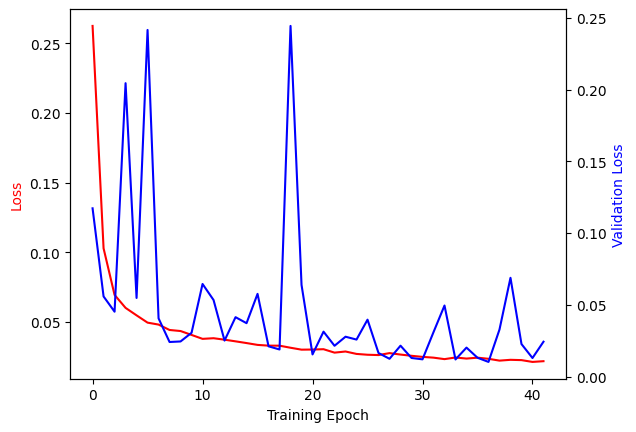

In [29]:
#
# Random forest does not generate a training history
#
if history is not None:
    plot_training_history(history.history['loss'],
                          history.history['val_loss'],
                          skip=8)

### Verify the operation of the model

We must verify the model is working across feature space. To do this we create a new set of scenarios and as the model to predict, we then compare to values generated by the original mathematical version. 

In [30]:
# Create new set of test scenarios
#
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=20)

In [31]:
# Only use scaler if we trained with scaled data.
#
scaler=None

**Note**
There are three scenarios below, only run one of them at a time as they all return results to the same outputs. 
These outputs are used to plot the graphs that inspect the accuracy of the results. You can come back and run a different scenario and re-plot.

In [ ]:
# Calculate : Rate vs Vol Scenario
#
s1,s1n,s2,s2n,actual = two_d_scenario(spot=99, strike=100, mat=0.75, rate=rates,vol=vols, price_func=black_scholes_model)
s1,s1n,s2,s2n,predicted = two_d_scenario(spot=99, strike=100, mat=0.75, rate=rates,vol=vols, price_func=model.predict, scaler=scaler)

In [38]:
# Calculate : Maturity vs Vol Scenario
#
s1,s1n,s2,s2n,actual = two_d_scenario(spot=99, strike=100, mat=mats, rate=0.05,vol=vols, price_func=black_scholes_model)
s1,s1n,s2,s2n,predicted = two_d_scenario(spot=99, strike=100, mat=mats, rate=0.05,vol=vols, price_func=model.predict, scaler=scaler)

0 % Complete
5 % Complete
10 % Complete
15 % Complete
20 % Complete
25 % Complete
30 % Complete
35 % Complete
40 % Complete
45 % Complete
50 % Complete
55 % Complete
60 % Complete
65 % Complete
70 % Complete
75 % Complete
80 % Complete
85 % Complete
90 % Complete
95 % Complete
Done
1/1 [==============================] - 0s 15ms/step
0 % Complete
1/1 [==============================] - 0s 15ms/step
5 % Complete
1/1 [==============================] - 0s 15ms/step
10 % Complete
1/1 [==============================] - 0s 15ms/step
15 % Complete
1/1 [==============================] - 0s 13ms/step
20 % Complete
1/1 [==============================] - 0s 14ms/step
25 % Complete
1/1 [==============================] - 0s 14ms/step
30 % Complete
1/1 [==============================] - 0s 14ms/step
35 % Complete
1/1 [==============================] - 0s 15ms/step
40 % Complete
1/1 [==============================] - 0s 16ms/step
45 % Complete
1/1 [==============================] - 0s 16ms/step
50 % Co

In [42]:
# Calculate : Spot vs Strike
#
s1,s1n,s2,s2n,actual = two_d_scenario(spot=spots, strike=strikes, mat=1.0, rate=0.05,vol=.2, price_func=black_scholes_model)
s1,s1n,s2,s2n,predicted = two_d_scenario(spot=spots, strike=strikes, mat=1.0, rate=0.05,vol=0.2, price_func=model.predict, scaler=scaler)

0 % Complete
5 % Complete
10 % Complete
15 % Complete
20 % Complete
25 % Complete
30 % Complete
35 % Complete
40 % Complete
45 % Complete
50 % Complete
55 % Complete
60 % Complete
65 % Complete
70 % Complete
75 % Complete
80 % Complete
85 % Complete
90 % Complete
95 % Complete
Done
1/1 [==============================] - 0s 14ms/step
0 % Complete
1/1 [==============================] - 0s 18ms/step
5 % Complete
1/1 [==============================] - 0s 15ms/step
10 % Complete
1/1 [==============================] - 0s 15ms/step
15 % Complete
1/1 [==============================] - 0s 16ms/step
20 % Complete
1/1 [==============================] - 0s 14ms/step
25 % Complete
1/1 [==============================] - 0s 14ms/step
30 % Complete
1/1 [==============================] - 0s 14ms/step
35 % Complete
1/1 [==============================] - 0s 15ms/step
40 % Complete
1/1 [==============================] - 0s 13ms/step
45 % Complete
1/1 [==============================] - 0s 14ms/step
50 % Co

In [39]:
def plot_price_surface(xscen,
                       yscen,
                       actual,
                       predicted,
                       title,
                       xscen_lab,
                       yscen_lab):
    """
    Plot dual surface of actual vs predicted, with a contour plot of price difference as %
    
    :param xscen     : The scenario values for X Axis
    :param yscen     : The scenario values for Y Axis
    :param actual    : 2D Array of actual values for X and Y Scenarios
    :param predicted : 2D Array of neural net predicted values for X and Y Scenarios
    :param title     : Graph title
    :param xscen_lab : X Axis label
    :param yscen_lab : Y Axis label
    """
    minz = min(np.min(actual), np.min(predicted))
    maxz = max(np.max(actual), np.max(predicted))

    X, Y = np.meshgrid(xscen, yscen)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim3d(minz, maxz)
    c1 = ax.contourf(X, Y, ((actual-predicted)/np.maximum(1e-9,actual))*100.0,
                     levels=range(-100, 100, 1), cmap=cm.RdGy, offset=np.min(minz))
    s1 = ax.plot_surface(X, Y, actual, cmap=cm.coolwarm,
                         linewidth=0, edgecolor='none', alpha=.7)
    s2 = ax.plot_surface(X, Y, predicted, edgecolors='k',
                         linewidth=0.1, color='gray', alpha=.3)
    cax = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0 +
                       ((ax.get_position().height)*0.15), 0.02, (ax.get_position().height)*0.7])
    cb = fig.colorbar(c1, cax=cax)
    cb.ax.set_ylabel('% difference', rotation=270)
    ax.set_xlabel(xscen_lab)
    ax.set_ylabel(yscen_lab)
    ax.set_zlabel("Option Price")
    ax.set_title(title)
    plt.show()

## Actual vs Predicted

### Surface

We plot the actuals as a surface (blue-red) and then overlay the predicted as a translucent gray surface, so we can see where the two diverge. We also plot a contour of the % difference at every point.

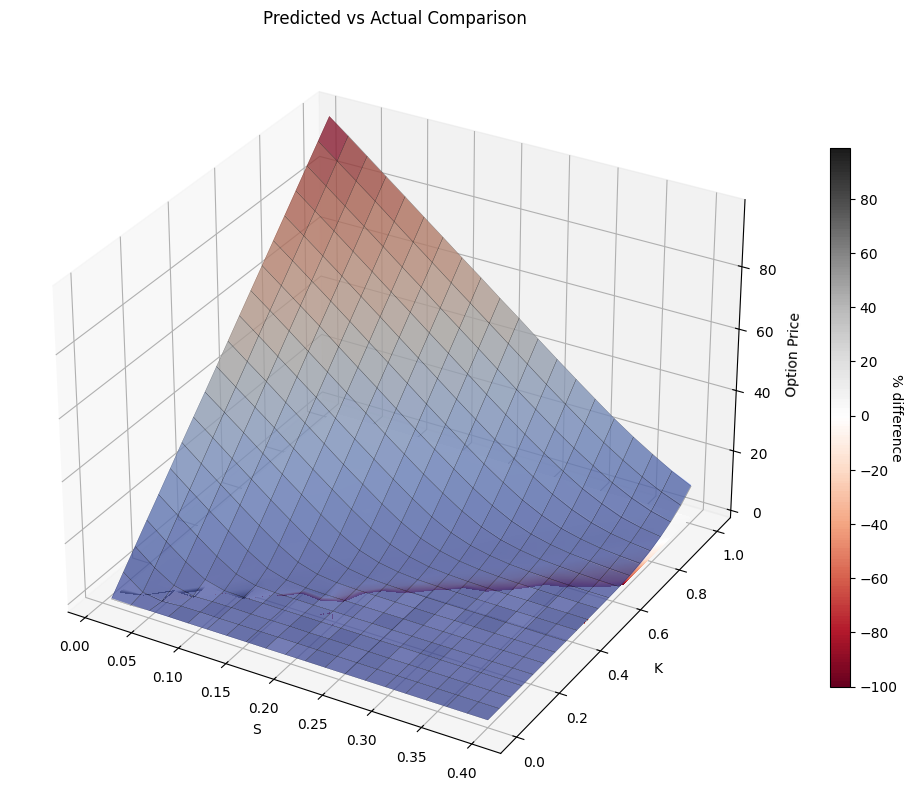

In [43]:
plot_price_surface(vols, # Can swap these next two to see different scenarios
                   mats, 
                   actual, 
                   predicted, 
                   title="Predicted vs Actual Comparison",
                   xscen_lab=s1n, 
                   yscen_lab=s2n)

### Scatter 
If we scatter plot actual vs predicted then we would expect to see a straight line, as for any given scenario point the actual and predicted would be equal.

In [73]:
def plot_scatter(
        actual,
        predicted,
        title,
        x_lab,
        y_lab):
    """
    Plot a scatter of actual vs predicted as a way to visualise differences.

    :param actual    : 1D Array of actual priced
    :param predicted : 1D Array of predicted 
    :param title     : Graph title
    :param x_lab     : X Axis label
    :param y_lab     : Y Axis label
    """
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.scatter(actual.flatten(), predicted.flatten(), s=0.25)
    plt.show()
    return

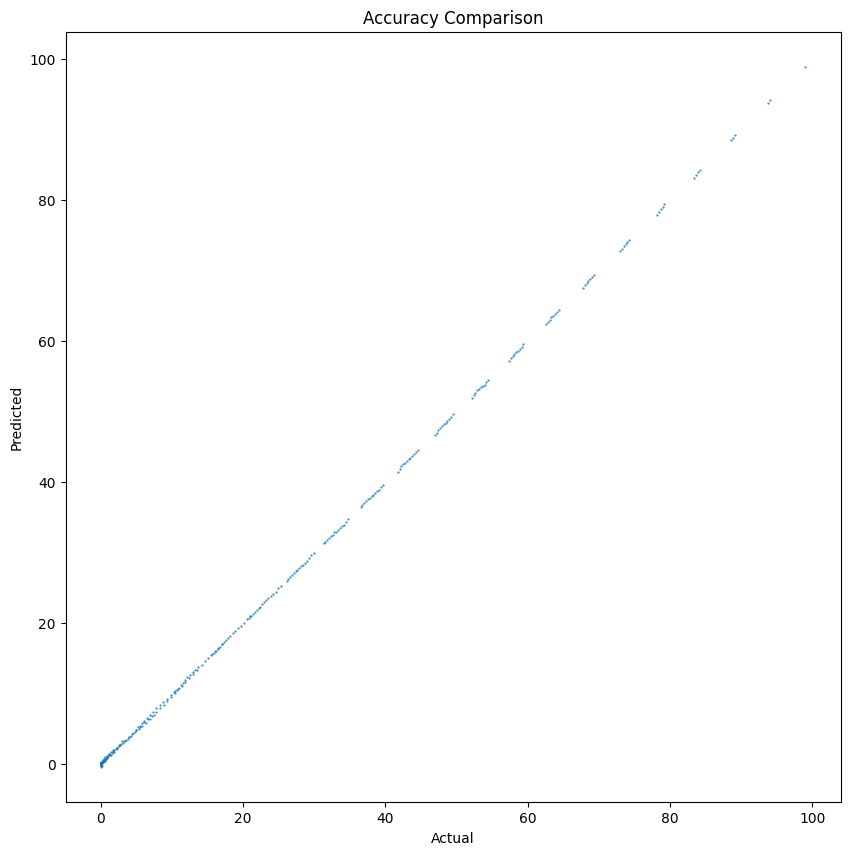

In [74]:
plot_scatter(actual.flatten(), predicted.flatten(), x_lab='Actual', y_lab='Predicted', title='Accuracy Comparison')

## Conclusion

We can see that it is possible to train a neural network for a financial contracts with a well behaved pay-off. We now add in an arbitrary feature that makes the pay-off harder to predict and type again.

In [120]:
price_max = np.round(np.max(actual.flatten()), 0)
price_min = np.round(np.min(actual.flatten()), 0)
barrier_min = (price_max - price_min)*.25
barrier_max = (price_max - price_min)*.5

In [135]:
def smooth_barrier(p: float,
                   S: float,
                   v: float,
                   T: float,
                   barrier_spot_min: float,
                   barrier_spot_max: float) -> float:
    """
    Takes the current option price and reduces it smoothly, but sharply if the spot price in the the min/bax barrier range.
    :param p: Unmodified option price
    :param s: spot used to generate the given unmodified option price
    :param v: vol used to generate the given unmodified option price
    :param T: Maturity used to generate the given unmodified option price
    :param barrier_spot_min: The spot price above which the barrier operator is active
    :param barrier_spot_max: The spot price below which the barrier operator is active
    :return: Modified option price.
    """
    scale_down = float(1)
    if S >= barrier_spot_min and S <= barrier_spot_max:
        scale_down = 1 - np.sin(((S - barrier_spot_min) / (barrier_spot_max - barrier_spot_min)) * np.pi)

    return p * scale_down

In [136]:
# Pre-fill the additional params to barrier, so function conforms with expected prototype
#
smb = partial(smooth_barrier, 
              barrier_spot_min=barrier_min,
              barrier_spot_max=barrier_max)

38.184101377939484

In [147]:
# Run quick simulation to show shape of barrier
#
opt_prc = []
spot_prc = []
for s in range(1,100):
    opt_prc.append(black_scholes_model(S=s, K=10, T=1.0,
                   r=0.05, v=0.3, o=0, barrier=smb))
    spot_prc.append(s)


In [151]:
def plot_line(
        x,
        y,
        title="",
        x_lab="",
        y_lab=""):
    """
    Simple line plot of a single variable.

    :param x         : 1D Array of x values to plot.
    :param y         : 1D Array of y values to plot.
    :param title     : Graph title
    :param x_lab     : X Axis label
    :param y_lab     : Y Axis label
    """
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.plot(x,y)
    plt.show()
    return

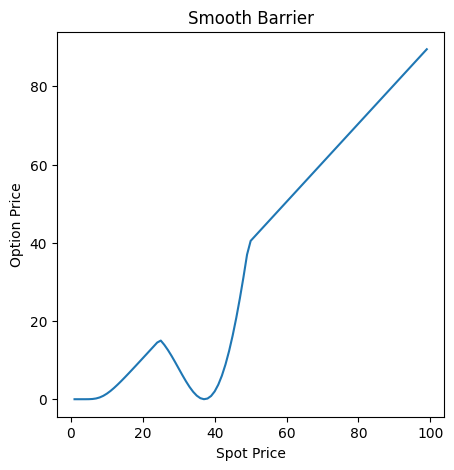

In [152]:
plot_line(x=spot_prc, y=opt_prc,title="Smooth Barrier",x_lab="Spot Price",y_lab="Option Price")

In [ ]:
#
# https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/black_scholes/crr_binomial_tree_test.py
#

def _get_payoff_fn(strikes, is_call_options):
    """Constructs the payoff functions."""
    option_signs = tf.cast(is_call_options, dtype=strikes.dtype) * 2 - 1

    def payoff(spots):
        """Computes payff for the specified options given the spot grid.

        Args:
          spots: Tensor of shape [batch_size, grid_size, 1]. The spot values at some
            time.

        Returns:
          Payoffs for exercise at the specified strikes.
        """
        return tf.nn.relu((spots - strikes) * option_signs)

    return payoff


def _get_value_modifier(is_american, payoff_fn):
    """Constructs the value modifier for american style exercise."""

    def modifier(values, spots):
        immediate_exercise_value = payoff_fn(spots)
        return tf.where(is_american,
                        tf.math.maximum(immediate_exercise_value, values), values)

    return modifier


def option_price_binomial(*,
                          volatilities,
                          strikes,
                          expiries,
                          spots,
                          discount_rates=None,
                          dividend_rates=None,
                          is_call_options=None,
                          is_american=None,
                          num_steps=100,
                          dtype=None,
                          name=None):
    """Computes the BS price for a batch of European or American options.

    Uses the Cox-Ross-Rubinstein version of the binomial tree method to compute
    the price of American or European options. Supports batching of the options
    and allows mixing of European and American style exercises in a batch.
    For more information about the binomial tree method and the
    Cox-Ross-Rubinstein method in particular see the references below.

    #### Example

    ```python
    # Prices 5 options with a mix of Call/Put, American/European features
    # in a single batch.
    dtype = np.float64
    spots = np.array([1.0, 2.0, 3.0, 4.0, 5.0], dtype=dtype)
    strikes = np.array([3.0, 3.0, 3.0, 3.0, 3.0], dtype=dtype)
    volatilities = np.array([0.1, 0.22, 0.32, 0.01, 0.4], dtype=dtype)
    is_call_options = np.array([True, True, False, False, False])
    is_american = np.array([False, True, True, False, True])
    discount_rates = np.array(0.035, dtype=dtype)
    dividend_rates = np.array([0.02, 0.0, 0.07, 0.01, 0.0], dtype=dtype)
    expiries = np.array(1.0, dtype=dtype)

    prices = option_price_binomial(
        volatilities=volatilities,
        strikes=strikes,
        expiries=expiries,
        spots=spots,
        discount_rates=discount_rates,
        dividend_rates=dividend_rates,
        is_call_options=is_call_options,
        is_american=is_american,
        dtype=dtype)
    # Prints [0., 0.0098847, 0.41299509, 0., 0.06046989]
    ```

    #### References

    [1] Hull, John C., Options, Futures and Other Derivatives. Pearson, 2018.
    [2] Wikipedia contributors. Binomial Options Pricing Model. Available at:
      https://en.wikipedia.org/wiki/Binomial_options_pricing_model

    Args:
      volatilities: Real `Tensor` of any shape and dtype. The volatilities to
        expiry of the options to price.
      strikes: A real `Tensor` of the same dtype and compatible shape as
        `volatilities`. The strikes of the options to be priced.
      expiries: A real `Tensor` of same dtype and compatible shape as
        `volatilities`. The expiry of each option. The units should be such that
        `expiry * volatility**2` is dimensionless.
      spots: A real `Tensor` of any shape that broadcasts to the shape of the
        `volatilities`. The current spot price of the underlying.
      discount_rates: An optional real `Tensor` of same dtype as the
        `volatilities`. The risk free discount rate. If None the rate is assumed
        to be 0.
        Default value: None, equivalent to discount rates = 0..
      dividend_rates: An optional real `Tensor` of same dtype as the
        `volatilities`. If None the rate is assumed to be 0.
        Default value: None, equivalent to discount rates = 1.
      is_call_options: A boolean `Tensor` of a shape compatible with
        `volatilities`. Indicates whether the option is a call (if True) or a put
        (if False). If not supplied, call options are assumed.
        Default value: None, equivalent to is_call_options = True.
      is_american: A boolean `Tensor` of a shape compatible with `volatilities`.
        Indicates whether the option exercise style is American (if True) or
        European (if False). If not supplied, European style exercise is assumed.
        Default value: None, equivalent to is_american = False.
      num_steps: A positive scalar int32 `Tensor`. The size of the time
        discretization to use.
        Default value: 100.
      dtype: Optional `tf.DType`. If supplied, the dtype to be used for conversion
        of any supplied non-`Tensor` arguments to `Tensor`.
        Default value: None which maps to the default dtype inferred by TensorFlow
          (float32).
      name: str. The name for the ops created by this function.
        Default value: None which is mapped to the default name `option_price`.

    Returns:
      A `Tensor` of the same shape as the inferred batch shape of the input data.
      The Black Scholes price of the options computed on a binomial tree.
    """
    with tf.name_scope(name or 'crr_option_price'):
        strikes = tf.convert_to_tensor(strikes, dtype=dtype, name='strikes')
        dtype = strikes.dtype
        volatilities = tf.convert_to_tensor(
            volatilities, dtype=dtype, name='volatilities')
        expiries = tf.convert_to_tensor(expiries, dtype=dtype, name='expiries')
        spots = tf.convert_to_tensor(spots, dtype=dtype, name='spots')

        if discount_rates is None:
            discount_rates = tf.zeros_like(volatilities)
        else:
            discount_rates = tf.convert_to_tensor(
                discount_rates, dtype=dtype, name='discount_rates')
        if dividend_rates is None:
            dividend_rates = tf.zeros_like(volatilities)
        else:
            dividend_rates = tf.convert_to_tensor(
                dividend_rates, dtype=dtype, name='dividend_rates')
        if is_call_options is None:
            is_call_options = tf.ones_like(
                volatilities, dtype=tf.bool, name='is_call_options')
        else:
            is_call_options = tf.convert_to_tensor(
                is_call_options, dtype=tf.bool, name='is_call_options')
        if is_american is None:
            is_american = tf.zeros_like(
                volatilities, dtype=tf.bool, name='is_american')
        else:
            is_american = tf.convert_to_tensor(
                is_american, dtype=tf.bool, name='is_american')

        num_steps = tf.cast(num_steps, dtype=dtype)
        dt = expiries / num_steps

        # CRR choices for the up and down move multipliers
        ln_up = volatilities * tf.math.sqrt(dt)
        ln_dn = -ln_up

        # Prepares the spot grid.
        grid_idx = tf.range(num_steps + 1)
        # Stores the grid as shape [input_batch, N + 1] where N = num_steps.
        log_spot_grid_1 = tf.expand_dims(
            tf.math.log(spots) + ln_up * num_steps, axis=-1)
        log_spot_grid_2 = tf.expand_dims(ln_dn - ln_up, axis=-1) * grid_idx
        log_spot_grid = log_spot_grid_1 + log_spot_grid_2

        # Adding the new dimension is to ensure that batch shape is at the front.
        payoff_fn = _get_payoff_fn(
            tf.expand_dims(strikes, axis=-1),
            tf.expand_dims(is_call_options, axis=-1))
        value_mod_fn = _get_value_modifier(
            tf.expand_dims(is_american, axis=-1), payoff_fn)

        # Shape [batch shape, num time steps + 1]
        values_grid = payoff_fn(tf.math.exp(log_spot_grid))

        p_up = tf.math.exp((discount_rates - dividend_rates) * dt + ln_up) - 1
        p_up /= tf.math.exp(2 * ln_up) - 1
        p_up = tf.expand_dims(p_up, axis=-1)
        p_dn = 1 - p_up
        discount_factors = tf.expand_dims(
            tf.math.exp(-discount_rates * dt), axis=-1)
        ln_up = tf.expand_dims(ln_up, axis=-1)

        def one_step_back(current_values, current_log_spot_grid):
            next_values = (current_values[..., 1:] * p_dn
                           + current_values[..., :-1] * p_up)
            next_log_spot_grid = current_log_spot_grid[..., :-1] - ln_up
            next_values = value_mod_fn(
                next_values, tf.math.exp(next_log_spot_grid))
            return discount_factors * next_values, next_log_spot_grid

        def should_continue(current_values, current_log_spot_grid):
            del current_values, current_log_spot_grid
            return True

        batch_shape = values_grid.shape[:-1]
        pv, _ = tf.while_loop(
            should_continue,
            one_step_back, (values_grid, log_spot_grid),
            maximum_iterations=tf.cast(num_steps, dtype=tf.int32),
            shape_invariants=(tf.TensorShape(batch_shape + [None]),
                              tf.TensorShape(batch_shape + [None])))
        return tf.where(
            expiries > 0,
            tf.squeeze(pv, axis=-1),
            tf.where(is_call_options,
                     tf.math.maximum(spots - strikes, 0),
                     tf.math.maximum(strikes - spots, 0)))

In [ ]:
f = open("training.csv", "w")
res = []
v = 0.05
for i in range(100):
    v += 0.05
    res.append(np.float64(option_price_binomial(volatilities=v,
                          strikes=3.0,
                          expiries=1.0,
                          spots=3.0,
                          discount_rates=0.035,
                          dividend_rates=0.07,
                          is_call_options=False,
                          is_american=True,
                          num_steps=100,
                          dtype=np.float64)))
print(res)

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(res, color='r')
plt.show()

## Extend feature set

We need to extend the feature set to cover the option style, Call or Put and early exercise or not, American or European

These string features needed encoding as numerical values so they can be passed to the model.

In [ ]:
# Generate features without type and style.
vols, mats, spots, strikes, rates = parameter_scenarios(num_steps=20)
X = generate_model_scenarios(spot=spots, strike=strikes, mat=mats, rate=rates, vol=vols)

In [ ]:
# Create all combinations with option type
# Call = 0, Put = 1
X = combinations(X, [0, 1])

In [ ]:
# Create all combinations with option style
# American (early exercise) = 0, European = 1
X = combinations(X, [0, 1])

In [ ]:
# Shuffle the training data
Xs = shuffle(X, random_state=42)
#scaler = MinMaxScaler(feature_range=(0, 1),copy=False).fit(Xs)
#Xss = scaler.transform(Xs)
dfxs = pd.DataFrame(Xs, columns=['spot', 'strike', 'maturity', 'rate', 'volatility','call_put','amer_eur'])
dfxs.to_csv('XFull.csv', encoding='ascii', index=False)

In [ ]:
!dir

In [ ]:
def run_scenarios(X_train):

    res = []
    for scen in X_train:
        S, K, T, r, v, cp, ae = np.round(scen, 8)
        value = np.round(option_price_binomial(volatilities=v,
                                               strikes=K,
                                               expiries=T,
                                               spots=S,
                                               discount_rates=r,
                                               dividend_rates=0.0,
                                               is_call_options=not (bool(cp)),
                                               is_american=not (bool(ae)),
                                               num_steps=200,
                                               dtype=np.float64), 8)
        res.append([S, K, T, r, v, cp, ae, value])
    return res

In [ ]:
# Create a new CSV file for results and write a header row.
f = open("binomial_training.csv", "w")
f.write(f"Spot, Strike, Maturity, rate, volatility, isPut, isEuropean\n")
f.close()

# Iterate over the pre-shuffled pandas X_train data in blocks, writing results out as we
# go. There are millions of training examples, so we want to make sure results are saved
# down. So, fo each block we flush, close and re-open the file in append mode.
base = 0
sz = 500
all = len(dfxs)

while base < all:
    # Open in append.
    f = open("binomial_training.csv", "a")

    pdx = dfxs.iloc[base:base+sz]
    X_train = (pdx).to_numpy()
    results = run_scenarios(X_train)
    for r in results:
        S, K, T, r, v, cp, ae, p = r
        f.write(f"{S},{K},{T},{r},{v},{cp},{ae},{p}\n")
    f.flush()
    f.close()
    base = base + sz
    print(f"{base} of {all}")